<a href="https://colab.research.google.com/github/jayanth142006/paddy-disease-classification/blob/main/paddy2(VGG19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Import from tensorflow.keras instead of just keras
import numpy as np
import os

In [ ]:
# Set the main directory containing subfolders of images
main_dir = "/content/drive/MyDrive/paddy"  # Change this to your main folder path
output_dir = "/content/drive/MyDrive/paddy2"  # Change this to your desired output directory
prefix = "image"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest"
)

# Loop through subfolders and images
print("[INFO] Processing images...")
for subdir, dirs, files in os.walk(main_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            image_path = os.path.join(subdir, file)
            rel_path = os.path.relpath(subdir, main_dir)
            save_subdir = os.path.join(output_dir, rel_path)
            os.makedirs(save_subdir, exist_ok=True)

            print(f"[INFO] Processing {image_path}...")
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)

            # Generate augmented images and save them
            total = 0
            imageGen = aug.flow(image, batch_size=1, save_to_dir=save_subdir,
                                 save_prefix=prefix, save_format="jpg")

            for img in imageGen:
                total += 1
                if total == 10:
                    break

print(f"[INFO] Augmented images saved in {output_dir}")

[INFO] Processing images...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_094238.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_094245.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_095421.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_094330.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_094308.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_095310.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_095010.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_094850.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_095008.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_095012.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_095315.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/hispa/IMG_20190419_094254.jpg...
[INFO] Proce

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_path = '/content/drive/MyDrive/paddy2'
img_size = (224, 224)
batch_size = 32
num_classes = 10  # Adjust based on your dataset

# Data Preprocessing (Augment Train, No Augment Validation)
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% train, 20% validation
)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen_valid.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5170 images belonging to 10 classes.
Found 1287 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import VGG19

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze All Convolutional Layers (Feature Extraction Phase)
for layer in base_model.layers:
    layer.trainable = False

# Build the Classifier on Top
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 2785s 17s/step - accuracy: 0.2550 - loss: 1.9872 - val_accuracy: 0.4336 - val_loss: 1.4202
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 147s 904ms/step - accuracy: 0.3693 - loss: 1.5096 - val_accuracy: 0.4895 - val_loss: 1.2691
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 201s 903ms/step - accuracy: 0.4221 - loss: 1.4009 - val_accuracy: 0.5618 - val_loss: 1.1458
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 149s 918ms/step - accuracy: 0.4446 - loss: 1.3478 - val_accuracy: 0.5688 - val_loss: 1.1149
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 145s 892ms/step - accuracy: 0.4802 - loss: 1.2643 - val_accuracy: 0.6068 - val_loss: 1.0341
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 147s 906ms/step - accuracy: 0.4855 - loss: 1.2292 - val_accuracy: 0.6092 - val_loss: 1.0040
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 147s 907ms/step - accuracy: 0.5169 - loss: 1.1839 - val_accuracy: 0.6247 - val_loss: 0.9831
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 204s 916ms/step - accuracy: 0.5275 - 

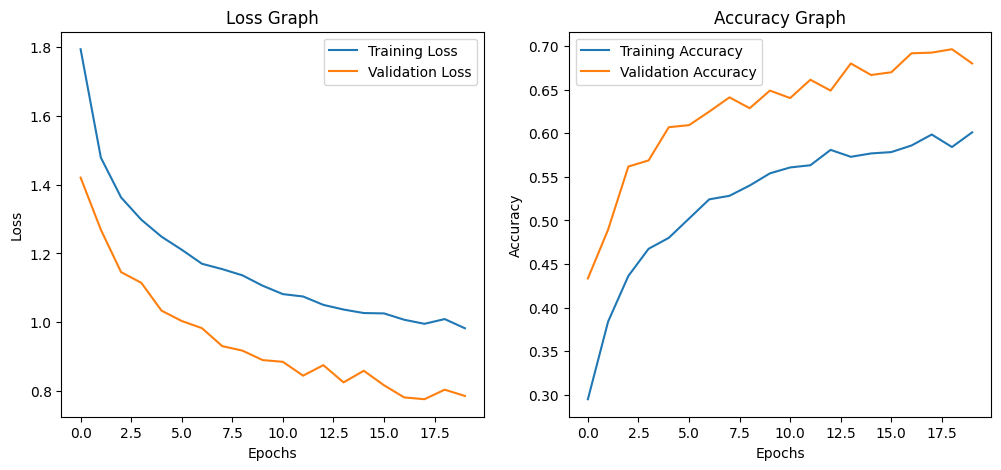

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step
Before Fine-Tuning:
                     precision    recall  f1-score   support

         False_smut       0.77      0.74      0.76       187
   bacterial_blight       0.78      0.79      0.78       260
              blast       0.65      0.70      0.67       192
          brownspot       0.56      0.34      0.42       189
grain_discoloration       1.00      0.59      0.74        27
              hispa       0.63      0.90      0.74       192
        leaf_streak       0.70      0.57      0.63        74
      sheath_blight       0.58      0.82      0.68        51
         sheath_rot       0.75      0.57      0.64        67
             tungro       0.79      0.79      0.79        48

           accuracy                           0.69      1287
          macro avg       0.72      0.68      0.69      1287
       weighted avg       0.69      0.69      0.68      1287



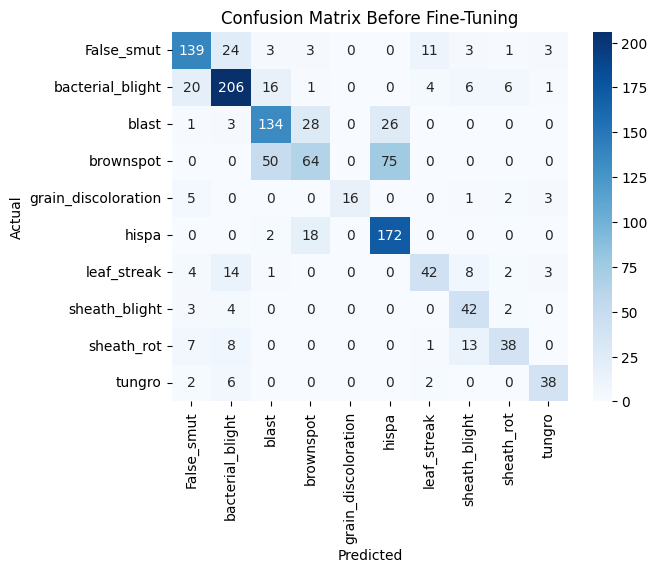

In [ ]:
# Evaluate Model
val_preds = model.predict(valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Classification Report
print("Before Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Fine-Tuning')
plt.show()

In [ ]:
for layer in base_model.layers[:16]:
    layer.trainable = False
for layer in base_model.layers[16:]:
    layer.trainable = True

# Compile Model with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 151s 933ms/step - accuracy: 0.9328 - loss: 0.1843 - val_accuracy: 0.9441 - val_loss: 0.1585
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 151s 934ms/step - accuracy: 0.9362 - loss: 0.1717 - val_accuracy: 0.9417 - val_loss: 0.1243
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 152s 937ms/step - accuracy: 0.9401 - loss: 0.1703 - val_accuracy: 0.9518 - val_loss: 0.1180
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 153s 944ms/step - accuracy: 0.9392 - loss: 0.1672 - val_accuracy: 0.9549 - val_loss: 0.1249
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 154s 950ms/step - accuracy: 0.9487 - loss: 0.1505 - val_accuracy: 0.9510 - val_loss: 0.1404


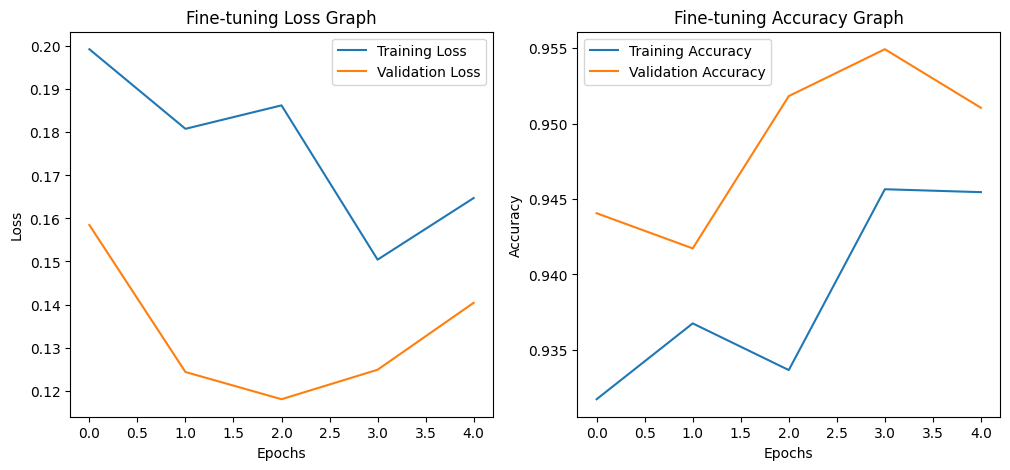

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 609ms/step
After Fine-Tuning:
                     precision    recall  f1-score   support

         False_smut       0.99      0.99      0.99       187
   bacterial_blight       1.00      0.98      0.99       260
              blast       0.93      0.96      0.95       192
          brownspot       0.97      0.76      0.85       189
grain_discoloration       1.00      1.00      1.00        27
              hispa       0.86      0.99      0.92       192
        leaf_streak       0.99      1.00      0.99        74
      sheath_blight       1.00      0.96      0.98        51
         sheath_rot       0.88      1.00      0.94        67
             tungro       1.00      1.00      1.00        48

           accuracy                           0.95      1287
          macro avg       0.96      0.97      0.96      1287
       weighted avg       0.96      0.95      0.95      1287



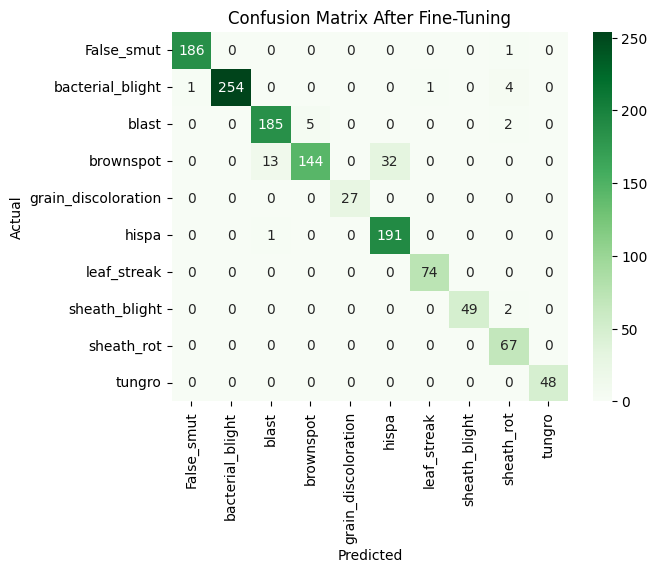

In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()